In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import torch
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Task 1. 데이터 준비하기

In [ ]:
# Task 1-1. 파일을 다운로드 받고, ratings.csv 파일을 읽어서 80% 20% 비율의 train, test 데이터로 나누기

ratings_data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/데이터과학/data/ratings.csv").dropna()

ratings_train = ratings_data.sample(frac=0.8, random_state = 32)
ratings_test = ratings_data.drop(ratings_train.index)

ratings_train = pd.DataFrame(ratings_train.reset_index())
ratings_test = pd.DataFrame(ratings_test.reset_index())

ratings_test

,index,userId,movieId,rating,timestamp
0,0,1,1,4.0,964982703
1,4,1,50,5.0,964982931
2,6,1,101,5.0,964980868
3,9,1,157,5.0,964984100
4,10,1,163,5.0,964983650
...,...,...,...,...,...
20162,100815,610,158721,3.5,1479542491
20163,100820,610,160341,2.5,1479545749
20164,100826,610,162350,3.5,1493849971
20165,100828,610,163981,3.5,1493850155


In [ ]:
# Task 1-2. movies.csv 파일을 읽고, 장르를 집합으로 변환하기

movies_data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/데이터과학/data/movies.csv")
movies_data['genres'] = movies_data['genres'].apply(lambda x: set(x.split('|')))

movies_data

,movieId,title,genres
0,1,Toy Story (1995),"{Comedy, Adventure, Fantasy, Children, Animation}"
1,2,Jumanji (1995),"{Fantasy, Children, Adventure}"
2,3,Grumpier Old Men (1995),"{Romance, Comedy}"
3,4,Waiting to Exhale (1995),"{Romance, Comedy, Drama}"
4,5,Father of the Bride Part II (1995),{Comedy}
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"{Action, Comedy, Fantasy, Animation}"
9738,193583,No Game No Life: Zero (2017),"{Comedy, Fantasy, Animation}"
9739,193585,Flint (2017),{Drama}
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"{Action, Animation}"


In [ ]:
# Task 1-3. tags.csv 파일을 읽고, tag들을 모두 소문자로 변환 후, 영화별로 tag들을 묶어서 집합으로 변환하기

tags_data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/데이터과학/data/tags.csv")
tags_data['tag'] = tags_data['tag'].str.lower()
tags_group = tags_data.groupby('movieId')['tag'].apply(lambda x : set(x))
tags_data = pd.DataFrame(tags_group.reset_index(name = 'tag'))

tags_data

,movieId,tag
0,1,"{fun, pixar}"
1,2,"{game, robin williams, magic board game, fantasy}"
2,3,"{moldy, old}"
3,5,"{remake, pregnancy}"
4,7,{remake}
...,...,...
1567,183611,"{rachel mcadams, funny, comedy}"
1568,184471,"{video game adaptation, adventure, alicia vika..."
1569,187593,"{sarcasm, ryan reynolds, josh brolin}"
1570,187595,"{emilia clarke, star wars}"


# Task 2. Latent Factor 모델을 이용하여 학습하기

In [ ]:
# Task 2-1. P, Q 등 파라미터 초기화 후, optimizer 등을 이용해서 학습하기

user = torch.LongTensor(ratings_train['userId'])
movie = torch.LongTensor(ratings_train['movieId'])
rating = torch.FloatTensor(ratings_train['rating'])

user_test = torch.LongTensor(ratings_test['userId'])
movie_test = torch.LongTensor(ratings_test['movieId'])
rating_test = torch.FloatTensor(ratings_test['rating'])

rank = 10
num_user = max(user.max(), user_test.max()) + 1
num_movie = max(movie.max(), movie_test.max()) + 1

P = torch.randn(num_user, rank, requires_grad=True)
Q = torch.randn(num_movie, rank, requires_grad=True)

bias_user = torch.randn(num_user, requires_grad=True)
bias_movie = torch.randn(num_movie, requires_grad=True)
mean = (rating.sum() / len(rating)).item()

optimizer = torch.optim.Adam([P,Q, bias_user, bias_movie], lr = 0.2)
lambda_P = 0.0001
lambda_Q = 0.0001
lambda_BU = 0.0001
lambda_BI = 0.0001

X = []
Y = []
Y_test = []

for epoch in range(1001):
    hypo = (P[user] * Q[movie]).sum(dim =1) + bias_user[user] + bias_movie[movie] + mean
    mse = F.mse_loss(hypo, rating)
    cost = mse + lambda_P * (P ** 2).sum() + lambda_Q * (Q ** 2).sum() + \
    lambda_BU * (bias_user ** 2).sum() + lambda_BI * (bias_movie ** 2).sum()

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    with torch.no_grad():
        hypo_test = (P[user_test] * Q[movie_test]).sum(dim =1) + bias_user[user_test] + bias_movie[movie_test] + mean
        mse_test = F.mse_loss(hypo_test,rating_test)
        
        X.append(epoch)
        Y.append(mse.item() ** 0.5)
        Y_test.append(mse_test.item() ** 0.5)

        if epoch %100 == 0:
            print(f"epoch: {epoch}, cost: {cost}, train_rmse: {mse.item() ** 0.5}, test_rmse: {mse_test.item() ** 0.5}")

epoch: 0, cost: 226.52908325195312, train_rmse: 3.595089737325257, test_rmse: 2.818348800628768
epoch: 100, cost: 0.5981249809265137, train_rmse: 0.631636197387804, test_rmse: 0.8718054904370172
epoch: 200, cost: 0.5874742269515991, train_rmse: 0.6212993737294202, test_rmse: 0.8677591724927559
epoch: 300, cost: 0.5854678750038147, train_rmse: 0.6183402727831014, test_rmse: 0.8656331815918243
epoch: 400, cost: 0.5847841501235962, train_rmse: 0.6171937531745995, test_rmse: 0.8650597251823884
epoch: 500, cost: 0.584559977054596, train_rmse: 0.6168509664366082, test_rmse: 0.8652025135106944
epoch: 600, cost: 0.5844915509223938, train_rmse: 0.6167750127008961, test_rmse: 0.865355988990856
epoch: 700, cost: 0.584455132484436, train_rmse: 0.6167424444300975, test_rmse: 0.8654135697158942
epoch: 800, cost: 0.5844430923461914, train_rmse: 0.616744280669155, test_rmse: 0.8654100226886646
epoch: 900, cost: 0.5844266414642334, train_rmse: 0.6167073132247259, test_rmse: 0.8654172200394172
epoch: 10

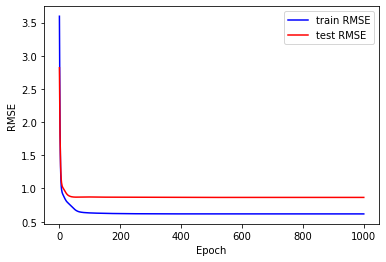

In [ ]:
# Task 2-2. (5 점) 학습데이터와 검증데이터에 대해서 각각 RMSE값을 구하여 출력하기

plt.plot(X,Y, c="b", label="train RMSE")
plt.plot(X,Y_test, c="r", label="test RMSE")

plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Task 3. 514번 User에게 추천하기

In [ ]:
#  Task 3-1. 514번 user의 예상 별점이 가장 높은 영화 20개를 찾아서 id 및 영화 이름 출력하기
data3_1 = pd.merge(ratings_data, movies_data, on = 'movieId')
data3_1 = pd.merge(data3_1, tags_data, on = 'movieId')

rating514 = data3_1.loc[(data3_1['userId'] == 514)]

rating514_movieId_set = set(rating514['movieId'].tolist())
hypoRating514 = []
for i in tqdm(range(num_movie)):
    if i in rating514_movieId_set:
        hypoRating514.append(-100)
    else:
        hypoRating514.append((P[514] * Q[i]).sum().item() + bias_user[514].item() + bias_movie[i].item() + mean)

hypoRating514 = [(i,v) for i,v in enumerate(hypoRating514) if i != 0]
hypoRating514.sort(key = lambda x:x[1], reverse = True)
hypoTopRating514 = hypoRating514[:20]

hypoTopRating514_movieId = [i[0] for i in hypoTopRating514]
hypoTopRating514_title = []
for i in range(len(hypoTopRating514_movieId)):
    hypoTopRating514_title.append(movies_data.loc[(movies_data['movieId'] == [i[0] for i in hypoTopRating514][i])]['title'].item())

pd.DataFrame({'movieId' : hypoTopRating514_movieId, 'title':hypoTopRating514_title})

100%|██████████| 193610/193610 [00:04<00:00, 44474.33it/s]


,movieId,title
0,527,Schindler's List (1993)
1,318,"Shawshank Redemption, The (1994)"
2,1204,Lawrence of Arabia (1962)
3,912,Casablanca (1942)
4,858,"Godfather, The (1972)"
5,1272,Patton (1970)
6,1250,"Bridge on the River Kwai, The (1957)"
7,2324,Life Is Beautiful (La Vita è bella) (1997)
8,953,It's a Wonderful Life (1946)
9,1221,"Godfather: Part II, The (1974)"


In [ ]:
# Task 3-2. 장르 및 tag를 기준으로, 514번 user가 5점을 준 영화들을 찾고, 각각의 영화와 가장 유사한 영화를 5개씩 찾아서 id, 영화 이름, 유사도 점수 출력하기

def jaccard_similarity(set1, set2):
    if len(set1 | set2) == 0:
        return 0
    return len(set1 & set2) / len(set1 | set2)

data3_2 = pd.merge(movies_data, tags_data, on = 'movieId')
rating514_5 = data3_1.loc[(data3_1['userId'] == 514) & (data3_1['rating'] == 5.0)]
rating514_5_sim = []

for i in tqdm(range(len(rating514_5))):
    marr = []
    m1 = rating514_5.iloc[i]
    m1_set = m1['genres'] | m1['tag']
    for j in range(len(data3_2)):
        m2 = data3_2.iloc[j]
        m2_set = m2['genres'] | m2['tag']
        jaccard = jaccard_similarity(m1_set, m2_set)
        if jaccard != 1:
            marr.append((m2['movieId'], m2['title'], jaccard))
    marr.sort(key = lambda x:x[2], reverse = True)
    rating514_5_sim.append(marr[:5])

for i in range(len(rating514_5)):
    print(rating514_5.iloc[i]['movieId'], rating514_5.iloc[i]['title'])
    print(pd.DataFrame({'movieId' : [i[0] for i in rating514_5_sim[i]], 'title' : [i[1] for i in rating514_5_sim[i]], \
                'score' : [i[2] for i in rating514_5_sim[i]]}))
    
    print()


100%|██████████| 11/11 [00:02<00:00,  3.97it/s]

260 Star Wars: Episode IV - A New Hope (1977)
   movieId                                              title     score
0     1210  Star Wars: Episode VI - Return of the Jedi (1983)  0.285714
1     1196  Star Wars: Episode V - The Empire Strikes Back...  0.259259
2    33493  Star Wars: Episode III - Revenge of the Sith (...  0.238095
3     1200                                      Aliens (1986)  0.222222
4   187595                     Solo: A Star Wars Story (2018)  0.173913

593 Silence of the Lambs, The (1991)
   movieId               title     score
0     4725    Session 9 (2001)  0.363636
1     6323     Identity (2003)  0.272727
2      628  Primal Fear (1996)  0.266667
3     8957          Saw (2004)  0.266667
4       22      Copycat (1995)  0.250000

1196 Star Wars: Episode V - The Empire Strikes Back (1980)
   movieId                                              title     score
0    33493  Star Wars: Episode III - Revenge of the Sith (...  0.384615
1     1210  Star Wars: Episode VI 

# Task 4. 영화 클러스터링하기

In [ ]:
#Task 4-1. cosine similarity를 기준으로 영화 벡터 (P혹은 Q)에서 k-means clustering

rating_movieId_set = []
for i in sorted(ratings_data['movieId'].tolist()):
    if i not in rating_movieId_set:
        rating_movieId_set.append(i)

Q_remove = Q
for i in tqdm(range(len(Q_remove)-1, 0, -1)):
    if i not in rating_movieId_set:
        Q_remove = torch.cat([Q_remove[:i], Q_remove[i+1:]])

100%|██████████| 193609/193609 [03:16<00:00, 983.99it/s] 


In [ ]:
#cosine = cosine_similarity(P.detach().numpy(),Q_remove.detach().numpy())
cosine = cosine_similarity(Q_remove.detach().numpy(),P.detach().numpy())

cost = []
for k in tqdm(range(1, 41)):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(cosine)
    cost.append(kmeans.inertia_)

100%|██████████| 40/40 [08:28<00:00, 12.71s/it]


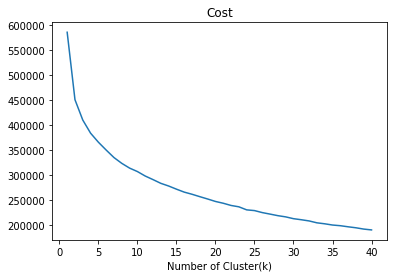

In [ ]:
#Task 4-2. (5 점) Task 4-1에서 구한 결과를 matplotlib를 활용하여 그래프로 그린 후 가장 적절해 보이는 k값 선택하기

plt.plot([x for x in range(1,41)],cost)

plt.xlabel('Number of Cluster(k)')
plt.title('Cost')
plt.show()
# 가장 적절한 k값은 10이다.

# Task 5. 차원 축소 및 시각화 

In [ ]:
# Task 5-1. P 행렬와 Q 행렬을 합쳐 Z행렬 만들기

Z = torch.cat([P,Q_remove], dim=0)

In [ ]:
# Task 5-2. Z 행렬에서 PCA 수행하여 2차원 데이터로 줄인 Zp 만들기

pca = PCA(n_components = 2)
Zp = pca.fit_transform(Z.detach().numpy())

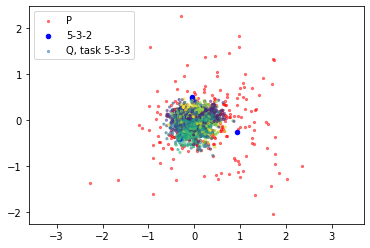

In [ ]:
# Task 5-3. matplotlib을 활용하여 Zp의 scatter plot 그리기

# Task 5-3-1. P행렬과 Q행렬의 점들을 서로 다른 색으로 그리기
plt.scatter(Zp[:len(P), 0], Zp[:len(P), 1], s = 5, c = 'r', alpha=0.5, label = 'P')

# Task 5-3-2. Task 3-1의 결과 점들을 다른 색으로 그려 강조하기
Z2 = P[514].unsqueeze(0)
for i in [j[0] for j in hypoTopRating514]:
    Z2 = torch.cat([Z2,Q[i].unsqueeze(0)], dim=0)

Zp2 = pca.fit_transform(Z2.detach().numpy())
plt.scatter(Zp2[1:, 0], Zp2[1:, 1], s = 20, c = 'b', alpha=1, label = '5-3-2')

# Task 5-3-3. Task 4-2의 k값으로 구한 cluster들을 각기 다른 색으로 그리기
plt.scatter(Zp[len(P):, 0], Zp[len(P):, 1], s = 5, c = kmeans.labels_, alpha=0.5 , label = 'Q, task 5-3-3')

plt.legend()
plt.axis('equal')
plt.show()